In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 2000)
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim

import gc
from sklearn.metrics import roc_auc_score

from scipy import spatial

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sktime.transformations.panel.catch22 import Catch22
from sktime.datatypes import check_raise

# Remove printing error
pd.options.mode.chained_assignment = None

In [2]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


# Functions

In [3]:
columns_to_drop = [
 'Diastolic Blood Pressure2',
 'Diastolic Blood Pressure3',
 'Diastolic Blood Pressure4',
 'Diastolic Blood Pressure5',
 'Diastolic Blood Pressure6',
 'Diastolic Blood Pressure7',
 'Diastolic Blood Pressure8',
 'Diastolic Blood Pressure9',
 'Diastolic Blood Pressure11',
 'Diastolic Blood Pressure12',
 'Diastolic Blood Pressure13',
 'Diastolic Blood Pressure14',
 'Diastolic Blood Pressure15',
 'Diastolic Blood Pressure16',
 'Diastolic Blood Pressure18',
 'Diastolic Blood Pressure19',
 'Diastolic Blood Pressure20',
 'Diastolic Blood Pressure21',
 'Diastolic Blood Pressure2_current_stay',
 'Diastolic Blood Pressure3_current_stay',
 'Diastolic Blood Pressure4_current_stay',
 'Diastolic Blood Pressure5_current_stay',
 'Diastolic Blood Pressure6_current_stay',
 'Diastolic Blood Pressure8_current_stay',
 'Diastolic Blood Pressure12_current_stay',
 'Diastolic Blood Pressure13_current_stay',
 'Diastolic Blood Pressure14_current_stay',
 'Diastolic Blood Pressure16_current_stay',
 'Diastolic Blood Pressure18_current_stay',
 'Diastolic Blood Pressure19_current_stay',
 'Diastolic Blood Pressure20_current_stay',
 'Diastolic Blood Pressure21_current_stay',
 'Glasgow Coma Score0',
 'Glasgow Coma Score1',
 'Glasgow Coma Score2',
 'Glasgow Coma Score3',
 'Glasgow Coma Score4',
 'Glasgow Coma Score5',
 'Glasgow Coma Score6',
 'Glasgow Coma Score7',
 'Glasgow Coma Score8',
 'Glasgow Coma Score9',
 'Glasgow Coma Score10',
 'Glasgow Coma Score11',
 'Glasgow Coma Score12',
 'Glasgow Coma Score13',
 'Glasgow Coma Score14',
 'Glasgow Coma Score15',
 'Glasgow Coma Score16',
 'Glasgow Coma Score17',
 'Glasgow Coma Score18',
 'Glasgow Coma Score19',
 'Glasgow Coma Score20',
 'Glasgow Coma Score21',
 'Glasgow Coma Score0_current_stay',
 'Glasgow Coma Score1_current_stay',
 'Glasgow Coma Score2_current_stay',
 'Glasgow Coma Score3_current_stay',
 'Glasgow Coma Score4_current_stay',
 'Glasgow Coma Score5_current_stay',
 'Glasgow Coma Score6_current_stay',
 'Glasgow Coma Score7_current_stay',
 'Glasgow Coma Score8_current_stay',
 'Glasgow Coma Score10_current_stay',
 'Glasgow Coma Score11_current_stay',
 'Glasgow Coma Score12_current_stay',
 'Glasgow Coma Score13_current_stay',
 'Glasgow Coma Score14_current_stay',
 'Glasgow Coma Score15_current_stay',
 'Glasgow Coma Score16_current_stay',
 'Glasgow Coma Score17_current_stay',
 'Glasgow Coma Score18_current_stay',
 'Glasgow Coma Score19_current_stay',
 'Glasgow Coma Score20_current_stay',
 'Glasgow Coma Score21_current_stay',
 'Heart Rate2',
 'Heart Rate3',
 'Heart Rate4',
 'Heart Rate5',
 'Heart Rate6',
 'Heart Rate7',
 'Heart Rate8',
 'Heart Rate9',
 'Heart Rate11',
 'Heart Rate12',
 'Heart Rate13',
 'Heart Rate14',
 'Heart Rate15',
 'Heart Rate16',
 'Heart Rate18',
 'Heart Rate19',
 'Heart Rate20',
 'Heart Rate21',
 'Heart Rate2_current_stay',
 'Heart Rate3_current_stay',
 'Heart Rate4_current_stay',
 'Heart Rate5_current_stay',
 'Heart Rate6_current_stay',
 'Heart Rate8_current_stay',
 'Heart Rate12_current_stay',
 'Heart Rate13_current_stay',
 'Heart Rate14_current_stay',
 'Heart Rate16_current_stay',
 'Heart Rate18_current_stay',
 'Heart Rate19_current_stay',
 'Heart Rate20_current_stay',
 'Heart Rate21_current_stay',
 'Mean Arterial Pressure2',
 'Mean Arterial Pressure3',
 'Mean Arterial Pressure4',
 'Mean Arterial Pressure5',
 'Mean Arterial Pressure6',
 'Mean Arterial Pressure7',
 'Mean Arterial Pressure8',
 'Mean Arterial Pressure9',
 'Mean Arterial Pressure11',
 'Mean Arterial Pressure12',
 'Mean Arterial Pressure13',
 'Mean Arterial Pressure14',
 'Mean Arterial Pressure15',
 'Mean Arterial Pressure16',
 'Mean Arterial Pressure18',
 'Mean Arterial Pressure19',
 'Mean Arterial Pressure20',
 'Mean Arterial Pressure21',
 'Mean Arterial Pressure2_current_stay',
 'Mean Arterial Pressure3_current_stay',
 'Mean Arterial Pressure4_current_stay',
 'Mean Arterial Pressure5_current_stay',
 'Mean Arterial Pressure6_current_stay',
 'Mean Arterial Pressure8_current_stay',
 'Mean Arterial Pressure12_current_stay',
 'Mean Arterial Pressure13_current_stay',
 'Mean Arterial Pressure14_current_stay',
 'Mean Arterial Pressure16_current_stay',
 'Mean Arterial Pressure18_current_stay',
 'Mean Arterial Pressure19_current_stay',
 'Mean Arterial Pressure20_current_stay',
 'Mean Arterial Pressure21_current_stay',
 'NEWS Conscious Level Score0',
 'NEWS Conscious Level Score1',
 'NEWS Conscious Level Score2',
 'NEWS Conscious Level Score3',
 'NEWS Conscious Level Score4',
 'NEWS Conscious Level Score5',
 'NEWS Conscious Level Score6',
 'NEWS Conscious Level Score7',
 'NEWS Conscious Level Score8',
 'NEWS Conscious Level Score9',
 'NEWS Conscious Level Score10',
 'NEWS Conscious Level Score11',
 'NEWS Conscious Level Score12',
 'NEWS Conscious Level Score13',
 'NEWS Conscious Level Score14',
 'NEWS Conscious Level Score15',
 'NEWS Conscious Level Score16',
 'NEWS Conscious Level Score17',
 'NEWS Conscious Level Score18',
 'NEWS Conscious Level Score19',
 'NEWS Conscious Level Score20',
 'NEWS Conscious Level Score21',
 'NEWS Conscious Level Score0_current_stay',
 'NEWS Conscious Level Score1_current_stay',
 'NEWS Conscious Level Score2_current_stay',
 'NEWS Conscious Level Score3_current_stay',
 'NEWS Conscious Level Score4_current_stay',
 'NEWS Conscious Level Score5_current_stay',
 'NEWS Conscious Level Score6_current_stay',
 'NEWS Conscious Level Score7_current_stay',
 'NEWS Conscious Level Score8_current_stay',
 'NEWS Conscious Level Score9_current_stay',
 'NEWS Conscious Level Score10_current_stay',
 'NEWS Conscious Level Score11_current_stay',
 'NEWS Conscious Level Score12_current_stay',
 'NEWS Conscious Level Score13_current_stay',
 'NEWS Conscious Level Score14_current_stay',
 'NEWS Conscious Level Score15_current_stay',
 'NEWS Conscious Level Score16_current_stay',
 'NEWS Conscious Level Score17_current_stay',
 'NEWS Conscious Level Score18_current_stay',
 'NEWS Conscious Level Score19_current_stay',
 'NEWS Conscious Level Score20_current_stay',
 'NEWS Conscious Level Score21_current_stay',
 'NEWS Supplemental Oxygen Calc0',
 'NEWS Supplemental Oxygen Calc1',
 'NEWS Supplemental Oxygen Calc2',
 'NEWS Supplemental Oxygen Calc3',
 'NEWS Supplemental Oxygen Calc4',
 'NEWS Supplemental Oxygen Calc5',
 'NEWS Supplemental Oxygen Calc6',
 'NEWS Supplemental Oxygen Calc7',
 'NEWS Supplemental Oxygen Calc8',
 'NEWS Supplemental Oxygen Calc9',
 'NEWS Supplemental Oxygen Calc10',
 'NEWS Supplemental Oxygen Calc11',
 'NEWS Supplemental Oxygen Calc12',
 'NEWS Supplemental Oxygen Calc13',
 'NEWS Supplemental Oxygen Calc14',
 'NEWS Supplemental Oxygen Calc15',
 'NEWS Supplemental Oxygen Calc16',
 'NEWS Supplemental Oxygen Calc17',
 'NEWS Supplemental Oxygen Calc18',
 'NEWS Supplemental Oxygen Calc19',
 'NEWS Supplemental Oxygen Calc20',
 'NEWS Supplemental Oxygen Calc21',
 'NEWS Supplemental Oxygen Calc0_current_stay',
 'NEWS Supplemental Oxygen Calc1_current_stay',
 'NEWS Supplemental Oxygen Calc2_current_stay',
 'NEWS Supplemental Oxygen Calc3_current_stay',
 'NEWS Supplemental Oxygen Calc4_current_stay',
 'NEWS Supplemental Oxygen Calc5_current_stay',
 'NEWS Supplemental Oxygen Calc6_current_stay',
 'NEWS Supplemental Oxygen Calc7_current_stay',
 'NEWS Supplemental Oxygen Calc8_current_stay',
 'NEWS Supplemental Oxygen Calc9_current_stay',
 'NEWS Supplemental Oxygen Calc10_current_stay',
 'NEWS Supplemental Oxygen Calc11_current_stay',
 'NEWS Supplemental Oxygen Calc12_current_stay',
 'NEWS Supplemental Oxygen Calc13_current_stay',
 'NEWS Supplemental Oxygen Calc14_current_stay',
 'NEWS Supplemental Oxygen Calc15_current_stay',
 'NEWS Supplemental Oxygen Calc16_current_stay',
 'NEWS Supplemental Oxygen Calc17_current_stay',
 'NEWS Supplemental Oxygen Calc18_current_stay',
 'NEWS Supplemental Oxygen Calc19_current_stay',
 'NEWS Supplemental Oxygen Calc20_current_stay',
 'NEWS Supplemental Oxygen Calc21_current_stay',
 'Respiratory Rate0',
 'Respiratory Rate2',
 'Respiratory Rate3',
 'Respiratory Rate4',
 'Respiratory Rate5',
 'Respiratory Rate6',
 'Respiratory Rate7',
 'Respiratory Rate8',
 'Respiratory Rate9',
 'Respiratory Rate11',
 'Respiratory Rate12',
 'Respiratory Rate13',
 'Respiratory Rate14',
 'Respiratory Rate15',
 'Respiratory Rate16',
 'Respiratory Rate18',
 'Respiratory Rate19',
 'Respiratory Rate20',
 'Respiratory Rate21',
 'Respiratory Rate0_current_stay',
 'Respiratory Rate2_current_stay',
 'Respiratory Rate3_current_stay',
 'Respiratory Rate4_current_stay',
 'Respiratory Rate5_current_stay',
 'Respiratory Rate6_current_stay',
 'Respiratory Rate8_current_stay',
 'Respiratory Rate12_current_stay',
 'Respiratory Rate13_current_stay',
 'Respiratory Rate14_current_stay',
 'Respiratory Rate16_current_stay',
 'Respiratory Rate18_current_stay',
 'Respiratory Rate19_current_stay',
 'Respiratory Rate20_current_stay',
 'Respiratory Rate21_current_stay',
 'SpO20',
 'SpO22',
 'SpO23',
 'SpO24',
 'SpO25',
 'SpO26',
 'SpO27',
 'SpO28',
 'SpO29',
 'SpO211',
 'SpO212',
 'SpO213',
 'SpO214',
 'SpO215',
 'SpO216',
 'SpO218',
 'SpO219',
 'SpO220',
 'SpO221',
 'SpO20_current_stay',
 'SpO22_current_stay',
 'SpO23_current_stay',
 'SpO24_current_stay',
 'SpO25_current_stay',
 'SpO26_current_stay',
 'SpO28_current_stay',
 'SpO212_current_stay',
 'SpO213_current_stay',
 'SpO214_current_stay',
 'SpO216_current_stay',
 'SpO218_current_stay',
 'SpO219_current_stay',
 'SpO220_current_stay',
 'SpO221_current_stay',
 'Systolic Blood Pressure2',
 'Systolic Blood Pressure3',
 'Systolic Blood Pressure4',
 'Systolic Blood Pressure5',
 'Systolic Blood Pressure6',
 'Systolic Blood Pressure7',
 'Systolic Blood Pressure8',
 'Systolic Blood Pressure9',
 'Systolic Blood Pressure11',
 'Systolic Blood Pressure12',
 'Systolic Blood Pressure13',
 'Systolic Blood Pressure14',
 'Systolic Blood Pressure15',
 'Systolic Blood Pressure16',
 'Systolic Blood Pressure18',
 'Systolic Blood Pressure19',
 'Systolic Blood Pressure20',
 'Systolic Blood Pressure21',
 'Systolic Blood Pressure2_current_stay',
 'Systolic Blood Pressure3_current_stay',
 'Systolic Blood Pressure4_current_stay',
 'Systolic Blood Pressure5_current_stay',
 'Systolic Blood Pressure6_current_stay',
 'Systolic Blood Pressure8_current_stay',
 'Systolic Blood Pressure12_current_stay',
 'Systolic Blood Pressure13_current_stay',
 'Systolic Blood Pressure14_current_stay',
 'Systolic Blood Pressure16_current_stay',
 'Systolic Blood Pressure18_current_stay',
 'Systolic Blood Pressure19_current_stay',
 'Systolic Blood Pressure20_current_stay',
 'Systolic Blood Pressure21_current_stay',
 'Temperature0',
 'Temperature2',
 'Temperature3',
 'Temperature4',
 'Temperature5',
 'Temperature6',
 'Temperature7',
 'Temperature8',
 'Temperature9',
 'Temperature11',
 'Temperature12',
 'Temperature13',
 'Temperature14',
 'Temperature15',
 'Temperature16',
 'Temperature18',
 'Temperature19',
 'Temperature20',
 'Temperature21',
 'Temperature0_current_stay',
 'Temperature2_current_stay',
 'Temperature3_current_stay',
 'Temperature4_current_stay',
 'Temperature5_current_stay',
 'Temperature6_current_stay',
 'Temperature8_current_stay',
 'Temperature12_current_stay',
 'Temperature13_current_stay',
 'Temperature14_current_stay',
 'Temperature16_current_stay',
 'Temperature18_current_stay',
 'Temperature19_current_stay',
 'Temperature20_current_stay',
 'Temperature21_current_stay',
 'Diastolic Blood Pressure2_difference',
 'Diastolic Blood Pressure3_difference',
 'Diastolic Blood Pressure4_difference',
 'Diastolic Blood Pressure5_difference',
 'Diastolic Blood Pressure6_difference',
 'Diastolic Blood Pressure7_difference',
 'Diastolic Blood Pressure8_difference',
 'Diastolic Blood Pressure9_difference',
 'Diastolic Blood Pressure11_difference',
 'Diastolic Blood Pressure12_difference',
 'Diastolic Blood Pressure13_difference',
 'Diastolic Blood Pressure14_difference',
 'Diastolic Blood Pressure15_difference',
 'Diastolic Blood Pressure16_difference',
 'Diastolic Blood Pressure18_difference',
 'Diastolic Blood Pressure19_difference',
 'Diastolic Blood Pressure20_difference',
 'Diastolic Blood Pressure21_difference',
 'Diastolic Blood Pressure2_current_stay_difference',
 'Diastolic Blood Pressure3_current_stay_difference',
 'Diastolic Blood Pressure4_current_stay_difference',
 'Diastolic Blood Pressure5_current_stay_difference',
 'Diastolic Blood Pressure6_current_stay_difference',
 'Diastolic Blood Pressure8_current_stay_difference',
 'Diastolic Blood Pressure12_current_stay_difference',
 'Diastolic Blood Pressure13_current_stay_difference',
 'Diastolic Blood Pressure14_current_stay_difference',
 'Diastolic Blood Pressure16_current_stay_difference',
 'Diastolic Blood Pressure18_current_stay_difference',
 'Diastolic Blood Pressure19_current_stay_difference',
 'Diastolic Blood Pressure21_current_stay_difference',
 'Glasgow Coma Score0_difference',
 'Glasgow Coma Score1_difference',
 'Glasgow Coma Score2_difference',
 'Glasgow Coma Score3_difference',
 'Glasgow Coma Score4_difference',
 'Glasgow Coma Score5_difference',
 'Glasgow Coma Score6_difference',
 'Glasgow Coma Score7_difference',
 'Glasgow Coma Score8_difference',
 'Glasgow Coma Score9_difference',
 'Glasgow Coma Score10_difference',
 'Glasgow Coma Score11_difference',
 'Glasgow Coma Score12_difference',
 'Glasgow Coma Score13_difference',
 'Glasgow Coma Score14_difference',
 'Glasgow Coma Score15_difference',
 'Glasgow Coma Score16_difference',
 'Glasgow Coma Score17_difference',
 'Glasgow Coma Score18_difference',
 'Glasgow Coma Score19_difference',
 'Glasgow Coma Score20_difference',
 'Glasgow Coma Score21_difference',
 'Glasgow Coma Score0_current_stay_difference',
 'Glasgow Coma Score1_current_stay_difference',
 'Glasgow Coma Score2_current_stay_difference',
 'Glasgow Coma Score3_current_stay_difference',
 'Glasgow Coma Score4_current_stay_difference',
 'Glasgow Coma Score5_current_stay_difference',
 'Glasgow Coma Score6_current_stay_difference',
 'Glasgow Coma Score7_current_stay_difference',
 'Glasgow Coma Score8_current_stay_difference',
 'Glasgow Coma Score10_current_stay_difference',
 'Glasgow Coma Score11_current_stay_difference',
 'Glasgow Coma Score12_current_stay_difference',
 'Glasgow Coma Score13_current_stay_difference',
 'Glasgow Coma Score14_current_stay_difference',
 'Glasgow Coma Score15_current_stay_difference',
 'Glasgow Coma Score16_current_stay_difference',
 'Glasgow Coma Score17_current_stay_difference',
 'Glasgow Coma Score18_current_stay_difference',
 'Glasgow Coma Score19_current_stay_difference',
 'Glasgow Coma Score20_current_stay_difference',
 'Glasgow Coma Score21_current_stay_difference',
 'Heart Rate2_difference',
 'Heart Rate3_difference',
 'Heart Rate4_difference',
 'Heart Rate5_difference',
 'Heart Rate6_difference',
 'Heart Rate7_difference',
 'Heart Rate8_difference',
 'Heart Rate9_difference',
 'Heart Rate11_difference',
 'Heart Rate12_difference',
 'Heart Rate13_difference',
 'Heart Rate14_difference',
 'Heart Rate15_difference',
 'Heart Rate16_difference',
 'Heart Rate18_difference',
 'Heart Rate19_difference',
 'Heart Rate20_difference',
 'Heart Rate21_difference',
 'Heart Rate2_current_stay_difference',
 'Heart Rate3_current_stay_difference',
 'Heart Rate4_current_stay_difference',
 'Heart Rate5_current_stay_difference',
 'Heart Rate6_current_stay_difference',
 'Heart Rate8_current_stay_difference',
 'Heart Rate12_current_stay_difference',
 'Heart Rate13_current_stay_difference',
 'Heart Rate14_current_stay_difference',
 'Heart Rate16_current_stay_difference',
 'Heart Rate18_current_stay_difference',
 'Heart Rate19_current_stay_difference',
 'Heart Rate21_current_stay_difference',
 'Mean Arterial Pressure2_difference',
 'Mean Arterial Pressure3_difference',
 'Mean Arterial Pressure4_difference',
 'Mean Arterial Pressure5_difference',
 'Mean Arterial Pressure6_difference',
 'Mean Arterial Pressure7_difference',
 'Mean Arterial Pressure8_difference',
 'Mean Arterial Pressure9_difference',
 'Mean Arterial Pressure11_difference',
 'Mean Arterial Pressure12_difference',
 'Mean Arterial Pressure13_difference',
 'Mean Arterial Pressure14_difference',
 'Mean Arterial Pressure15_difference',
 'Mean Arterial Pressure16_difference',
 'Mean Arterial Pressure18_difference',
 'Mean Arterial Pressure19_difference',
 'Mean Arterial Pressure20_difference',
 'Mean Arterial Pressure21_difference',
 'Mean Arterial Pressure2_current_stay_difference',
 'Mean Arterial Pressure3_current_stay_difference',
 'Mean Arterial Pressure4_current_stay_difference',
 'Mean Arterial Pressure5_current_stay_difference',
 'Mean Arterial Pressure6_current_stay_difference',
 'Mean Arterial Pressure8_current_stay_difference',
 'Mean Arterial Pressure12_current_stay_difference',
 'Mean Arterial Pressure13_current_stay_difference',
 'Mean Arterial Pressure14_current_stay_difference',
 'Mean Arterial Pressure16_current_stay_difference',
 'Mean Arterial Pressure18_current_stay_difference',
 'Mean Arterial Pressure19_current_stay_difference',
 'Mean Arterial Pressure21_current_stay_difference',
 'NEWS Conscious Level Score0_difference',
 'NEWS Conscious Level Score1_difference',
 'NEWS Conscious Level Score2_difference',
 'NEWS Conscious Level Score3_difference',
 'NEWS Conscious Level Score4_difference',
 'NEWS Conscious Level Score5_difference',
 'NEWS Conscious Level Score6_difference',
 'NEWS Conscious Level Score7_difference',
 'NEWS Conscious Level Score8_difference',
 'NEWS Conscious Level Score9_difference',
 'NEWS Conscious Level Score10_difference',
 'NEWS Conscious Level Score11_difference',
 'NEWS Conscious Level Score12_difference',
 'NEWS Conscious Level Score13_difference',
 'NEWS Conscious Level Score14_difference',
 'NEWS Conscious Level Score15_difference',
 'NEWS Conscious Level Score16_difference',
 'NEWS Conscious Level Score17_difference',
 'NEWS Conscious Level Score18_difference',
 'NEWS Conscious Level Score19_difference',
 'NEWS Conscious Level Score20_difference',
 'NEWS Conscious Level Score21_difference',
 'NEWS Conscious Level Score0_current_stay_difference',
 'NEWS Conscious Level Score1_current_stay_difference',
 'NEWS Conscious Level Score2_current_stay_difference',
 'NEWS Conscious Level Score3_current_stay_difference',
 'NEWS Conscious Level Score4_current_stay_difference',
 'NEWS Conscious Level Score5_current_stay_difference',
 'NEWS Conscious Level Score6_current_stay_difference',
 'NEWS Conscious Level Score7_current_stay_difference',
 'NEWS Conscious Level Score8_current_stay_difference',
 'NEWS Conscious Level Score9_current_stay_difference',
 'NEWS Conscious Level Score10_current_stay_difference',
 'NEWS Conscious Level Score11_current_stay_difference',
 'NEWS Conscious Level Score12_current_stay_difference',
 'NEWS Conscious Level Score13_current_stay_difference',
 'NEWS Conscious Level Score14_current_stay_difference',
 'NEWS Conscious Level Score15_current_stay_difference',
 'NEWS Conscious Level Score16_current_stay_difference',
 'NEWS Conscious Level Score17_current_stay_difference',
 'NEWS Conscious Level Score18_current_stay_difference',
 'NEWS Conscious Level Score19_current_stay_difference',
 'NEWS Conscious Level Score20_current_stay_difference',
 'NEWS Conscious Level Score21_current_stay_difference',
 'NEWS Supplemental Oxygen Calc0_difference',
 'NEWS Supplemental Oxygen Calc1_difference',
 'NEWS Supplemental Oxygen Calc2_difference',
 'NEWS Supplemental Oxygen Calc3_difference',
 'NEWS Supplemental Oxygen Calc4_difference',
 'NEWS Supplemental Oxygen Calc5_difference',
 'NEWS Supplemental Oxygen Calc6_difference',
 'NEWS Supplemental Oxygen Calc7_difference',
 'NEWS Supplemental Oxygen Calc8_difference',
 'NEWS Supplemental Oxygen Calc9_difference',
 'NEWS Supplemental Oxygen Calc10_difference',
 'NEWS Supplemental Oxygen Calc11_difference',
 'NEWS Supplemental Oxygen Calc12_difference',
 'NEWS Supplemental Oxygen Calc13_difference',
 'NEWS Supplemental Oxygen Calc14_difference',
 'NEWS Supplemental Oxygen Calc15_difference',
 'NEWS Supplemental Oxygen Calc16_difference',
 'NEWS Supplemental Oxygen Calc17_difference',
 'NEWS Supplemental Oxygen Calc18_difference',
 'NEWS Supplemental Oxygen Calc19_difference',
 'NEWS Supplemental Oxygen Calc20_difference',
 'NEWS Supplemental Oxygen Calc21_difference',
 'NEWS Supplemental Oxygen Calc0_current_stay_difference',
 'NEWS Supplemental Oxygen Calc1_current_stay_difference',
 'NEWS Supplemental Oxygen Calc2_current_stay_difference',
 'NEWS Supplemental Oxygen Calc3_current_stay_difference',
 'NEWS Supplemental Oxygen Calc4_current_stay_difference',
 'NEWS Supplemental Oxygen Calc5_current_stay_difference',
 'NEWS Supplemental Oxygen Calc6_current_stay_difference',
 'NEWS Supplemental Oxygen Calc7_current_stay_difference',
 'NEWS Supplemental Oxygen Calc8_current_stay_difference',
 'NEWS Supplemental Oxygen Calc10_current_stay_difference',
 'NEWS Supplemental Oxygen Calc12_current_stay_difference',
 'NEWS Supplemental Oxygen Calc13_current_stay_difference',
 'NEWS Supplemental Oxygen Calc14_current_stay_difference',
 'NEWS Supplemental Oxygen Calc15_current_stay_difference',
 'NEWS Supplemental Oxygen Calc16_current_stay_difference',
 'NEWS Supplemental Oxygen Calc18_current_stay_difference',
 'NEWS Supplemental Oxygen Calc19_current_stay_difference',
 'NEWS Supplemental Oxygen Calc20_current_stay_difference',
 'NEWS Supplemental Oxygen Calc21_current_stay_difference',
 'Respiratory Rate2_difference',
 'Respiratory Rate3_difference',
 'Respiratory Rate4_difference',
 'Respiratory Rate5_difference',
 'Respiratory Rate6_difference',
 'Respiratory Rate7_difference',
 'Respiratory Rate8_difference',
 'Respiratory Rate9_difference',
 'Respiratory Rate11_difference',
 'Respiratory Rate12_difference',
 'Respiratory Rate13_difference',
 'Respiratory Rate14_difference',
 'Respiratory Rate15_difference',
 'Respiratory Rate16_difference',
 'Respiratory Rate18_difference',
 'Respiratory Rate19_difference',
 'Respiratory Rate20_difference',
 'Respiratory Rate21_difference',
 'Respiratory Rate0_current_stay_difference',
 'Respiratory Rate2_current_stay_difference',
 'Respiratory Rate3_current_stay_difference',
 'Respiratory Rate4_current_stay_difference',
 'Respiratory Rate5_current_stay_difference',
 'Respiratory Rate6_current_stay_difference',
 'Respiratory Rate8_current_stay_difference',
 'Respiratory Rate12_current_stay_difference',
 'Respiratory Rate13_current_stay_difference',
 'Respiratory Rate14_current_stay_difference',
 'Respiratory Rate16_current_stay_difference',
 'Respiratory Rate18_current_stay_difference',
 'Respiratory Rate19_current_stay_difference',
 'Respiratory Rate21_current_stay_difference',
 'SpO22_difference',
 'SpO23_difference',
 'SpO24_difference',
 'SpO25_difference',
 'SpO26_difference',
 'SpO27_difference',
 'SpO28_difference',
 'SpO29_difference',
 'SpO211_difference',
 'SpO212_difference',
 'SpO213_difference',
 'SpO214_difference',
 'SpO215_difference',
 'SpO216_difference',
 'SpO218_difference',
 'SpO219_difference',
 'SpO220_difference',
 'SpO221_difference',
 'SpO22_current_stay_difference',
 'SpO23_current_stay_difference',
 'SpO24_current_stay_difference',
 'SpO25_current_stay_difference',
 'SpO26_current_stay_difference',
 'SpO28_current_stay_difference',
 'SpO212_current_stay_difference',
 'SpO213_current_stay_difference',
 'SpO214_current_stay_difference',
 'SpO216_current_stay_difference',
 'SpO218_current_stay_difference',
 'SpO219_current_stay_difference',
 'SpO221_current_stay_difference',
 'Systolic Blood Pressure2_difference',
 'Systolic Blood Pressure3_difference',
 'Systolic Blood Pressure4_difference',
 'Systolic Blood Pressure5_difference',
 'Systolic Blood Pressure6_difference',
 'Systolic Blood Pressure7_difference',
 'Systolic Blood Pressure8_difference',
 'Systolic Blood Pressure9_difference',
 'Systolic Blood Pressure11_difference',
 'Systolic Blood Pressure12_difference',
 'Systolic Blood Pressure13_difference',
 'Systolic Blood Pressure14_difference',
 'Systolic Blood Pressure15_difference',
 'Systolic Blood Pressure16_difference',
 'Systolic Blood Pressure18_difference',
 'Systolic Blood Pressure19_difference',
 'Systolic Blood Pressure20_difference',
 'Systolic Blood Pressure21_difference',
 'Systolic Blood Pressure2_current_stay_difference',
 'Systolic Blood Pressure3_current_stay_difference',
 'Systolic Blood Pressure4_current_stay_difference',
 'Systolic Blood Pressure5_current_stay_difference',
 'Systolic Blood Pressure6_current_stay_difference',
 'Systolic Blood Pressure8_current_stay_difference',
 'Systolic Blood Pressure12_current_stay_difference',
 'Systolic Blood Pressure13_current_stay_difference',
 'Systolic Blood Pressure14_current_stay_difference',
 'Systolic Blood Pressure16_current_stay_difference',
 'Systolic Blood Pressure18_current_stay_difference',
 'Systolic Blood Pressure19_current_stay_difference',
 'Systolic Blood Pressure21_current_stay_difference',
 'Temperature2_difference',
 'Temperature3_difference',
 'Temperature4_difference',
 'Temperature5_difference',
 'Temperature6_difference',
 'Temperature7_difference',
 'Temperature8_difference',
 'Temperature9_difference',
 'Temperature11_difference',
 'Temperature12_difference',
 'Temperature13_difference',
 'Temperature14_difference',
 'Temperature15_difference',
 'Temperature16_difference',
 'Temperature18_difference',
 'Temperature19_difference',
 'Temperature20_difference',
 'Temperature21_difference',
 'Temperature2_current_stay_difference',
 'Temperature3_current_stay_difference',
 'Temperature4_current_stay_difference',
 'Temperature5_current_stay_difference',
 'Temperature6_current_stay_difference',
 'Temperature8_current_stay_difference',
 'Temperature12_current_stay_difference',
 'Temperature13_current_stay_difference',
 'Temperature14_current_stay_difference',
 'Temperature16_current_stay_difference',
 'Temperature18_current_stay_difference',
 'Temperature19_current_stay_difference',
 'Temperature21_current_stay_difference']

In [4]:
# Function to remove outliers
def remove_data_outliers(df, coeff=6, tol=0):
    """Utility function to remove data outliers from the data set using Z-Score method.
    Args:
        df (DataFrame): Input transformed data set.
        coeff (float, optional): Scaling coefficient for outlier removal strategy. Defaults to 6.
        tol (int, optional): Feature tolerance on how many features with NaN values may exist. Defaults to 0.
    Returns:
        Data set (DataFrame): Output data set without outlier values.
        Outliers per variable (Series): Number of outliers remaining per variable.
    """

    # Calculate IQR = Q3 - Q1
    q1, q3 = df.quantile(.25), df.quantile(.75)
    IQR = q3 - q1
    lower_bound = q1 - (coeff * IQR)
    upper_bound = q3 + (coeff * IQR)

    # Set the outliers to unique number
    df[(df < lower_bound) | (df > upper_bound)] = 999999999

    # Store number of outliers per column
    outlier_count = df[df == 999999999].count(axis=0)

    # Set the outliers to NaN
    df = df.replace(999999999, np.NaN)

    # Return complete profiles and outliers per column
    return df, outlier_count

In [6]:
def generate_synthetic_data(df, percentiles=None, trend=None, seed=0, new_df_length=10):
    synthetic_data = pd.DataFrame()
    np.random.seed(seed)  # Set a seed for reproducibility

    for col in df.columns:
        if percentiles and col in percentiles:
            # Specify the desired percentile range for each column
            lower_percentile, upper_percentile = percentiles[col]
            lower_limit = np.nanpercentile(df[col], lower_percentile)
            upper_limit = np.nanpercentile(df[col], upper_percentile)
            
            # Filter data within the specified percentile range
            within_percentile_range = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]
            
            # Calculate mean and std only within the specified percentile range
            mean, std = within_percentile_range[col].mean(), within_percentile_range[col].std()
            
            # Generate synthetic data by sampling from a Gaussian distribution
            synthetic_values = np.random.normal(loc=mean, scale=std, size=new_df_length)
            
            # Apply an increasing trend with a defined rate of change
            if trend and col in trend:
                rate_of_change = trend[col]
                synthetic_values += np.arange(len(synthetic_values)) * rate_of_change
            
            # Clip values to within the real data range
            synthetic_values = np.clip(synthetic_values, df[col].min(), df[col].max())
            
            synthetic_data[col] = synthetic_values
        else:
            # If no specific percentile range is specified, use the entire distribution
            # Calculate mean and std
            mean, std = df[col].mean(), df[col].std()
            # Generate synthetic data by sampling from a Gaussian distribution
            synthetic_values = np.random.normal(loc=mean, scale=std, size=new_df_length)

            # Apply an increasing trend with a defined rate of change
            if trend and col in trend:
                rate_of_change = trend[col]
                synthetic_values += np.arange(len(synthetic_values)) * rate_of_change
            
            # Clip values to within the real data range
            synthetic_values = np.clip(synthetic_values, df[col].min(), df[col].max())
            
            synthetic_data[col] = synthetic_values

    return synthetic_data

In [7]:
# Define C22 function
def c22_24_fun(df):
    c22 = Catch22(catch24=True) # Add catch24 = True
    master_df = pd.DataFrame()
    overlord_df = pd.DataFrame()
    remove_set = set()
    for x in range(len(df.columns)): # Iterate through columns so not to many nans
        print('column number:', x)
        working_df = df.iloc[:, x]
        working_df = working_df.to_frame()
        for column_name in working_df:
            master_df = pd.DataFrame()
            master_df2 = pd.DataFrame()
            for stay_id, new_df in working_df[[column_name]].groupby(level=0):
                    new_df2 = new_df.reset_index(drop=True).dropna()
                    
                    # C22 for current day
                    if len(new_df2) <= 2: # c22 only works with 3 or more timepoints
                        transformed_data = pd.DataFrame()
                        np_data = new_df2.to_numpy()
                        if not np_data.size == 0:
                            transformed_data['22'] = np.mean(new_df2.to_numpy())
                            transformed_data['23'] = np.std(new_df.to_numpy())
                    else:
                        transformed_data = c22.fit_transform(new_df2)

                    transformed_data = transformed_data.add_prefix(column_name)           
                    transformed_data.insert(0, 'SPELL_IDENTIFIER', stay_id)
                    transformed_data.insert(1, 'date', new_df.reset_index().iloc[-1]['date'])
                    transformed_data.insert(2, '24_hour_flag', 1)

                    # C22 for all data to date for stay - same for first 24 hours
                    transformed_data2 = transformed_data.iloc[:,3:].copy()
                    transformed_data2 = transformed_data2.add_suffix('_current_stay') # Indicate different as temporal over whole of current stay
                    transformed_data2.insert(0, 'SPELL_IDENTIFIER', stay_id)
                    transformed_data2.insert(1, 'date', new_df.reset_index().iloc[-1]['date'])
                    transformed_data2.insert(2, '24_hour_flag', 1)

                    # Create master df's
                    master_df = pd.concat([master_df, transformed_data])
                    master_df2 = pd.concat([master_df2, transformed_data2])


            master_df.reset_index(inplace=True, drop=True)
            master_df2.reset_index(inplace=True, drop=True)

            master_df = master_df.merge(master_df2, how='left', on=['SPELL_IDENTIFIER', 'date', '24_hour_flag'])

        if x == 0:
            overlord_df = master_df.copy()
        else:
            overlord_df = overlord_df.merge(master_df, how='outer', on=['SPELL_IDENTIFIER', 'date', '24_hour_flag'])
        
    return overlord_df

In [8]:
# Define C22 function
def c22_48_fun(df):
    c22 = Catch22(catch24=True)
    c22_2 = Catch22(catch24=True)
    master_df = pd.DataFrame()
    overlord_df = pd.DataFrame()
    remove_set = set()
    for x in range(len(df.columns)): # Iterate through columns so not to many nans
        print('column number:', x)
        working_df = df.iloc[:, x]
        working_df = working_df.to_frame()
        for column_name in working_df:
            master_df = pd.DataFrame()
            master_df2 = pd.DataFrame()
            for stay_id, new_df in working_df[[column_name]].groupby(level=0):

                    new_df2 = new_df.tail(4).reset_index(drop=True).dropna()
                    new_df3 = new_df.reset_index(drop=True).dropna()
                    
                    # C22 for latest day
                    if len(new_df2) <= 2: # c22 only works with 3 or more timepoints
                        transformed_data = pd.DataFrame()
                        np_data = new_df2.to_numpy()
                        if not np_data.size == 0:
                            transformed_data['22'] = np.mean(np_data)
                            transformed_data['23'] = np.std(np_data)
                    else: 
                        transformed_data = c22.fit_transform(new_df2)
                    transformed_data = transformed_data.add_prefix(column_name)           
                    transformed_data.insert(0, 'SPELL_IDENTIFIER', stay_id)
                    transformed_data.insert(1, 'date', new_df.reset_index().iloc[-1]['date'])
                    transformed_data.insert(2, '48_hour_flag', 1)

                    # C22 for all data to date for stay
                    if len(new_df3) <= 2: # c22 only works with 3 or more timepoints
                        transformed_data2 = pd.DataFrame()
                        np_data = new_df3.to_numpy()
                        if not np_data.size == 0:
                            transformed_data2['22'] = np.mean(np_data)
                            transformed_data2['23'] = np.std(np_data) 
                    else:
                        transformed_data2 = c22_2.fit_transform(new_df3)
                    transformed_data2 = transformed_data2.add_prefix(column_name)  
                    transformed_data2 = transformed_data2.add_suffix('_current_stay') # Indicate different as temporal over whole of current stay             
                    transformed_data2.insert(0, 'SPELL_IDENTIFIER', stay_id)
                    transformed_data2.insert(1, 'date', new_df.reset_index().iloc[-1]['date'])
                    transformed_data2.insert(2, '48_hour_flag', 1)

                    # Create master df's
                    master_df = pd.concat([master_df, transformed_data])
                    master_df2 = pd.concat([master_df2, transformed_data2])

            master_df.reset_index(inplace=True, drop=True)
            master_df2.reset_index(inplace=True, drop=True)

            master_df = master_df.merge(master_df2, how='left', on=['SPELL_IDENTIFIER', 'date', '48_hour_flag'])

        if x == 0:
            overlord_df = master_df.copy()
        else:
            overlord_df = overlord_df.merge(master_df, how='outer', on=['SPELL_IDENTIFIER', 'date', '48_hour_flag'])

    return overlord_df

In [9]:
def c22_other_fun(df):
    c22 = Catch22(catch24=True)
    master_df = pd.DataFrame()
    overlord_df = pd.DataFrame()
    for x in range(len(df.columns)): # Iterate through columns sas this c22 does not work on multiple columns
        print('column number:', x)
        working_df = df.iloc[:, x]
        working_df = working_df.to_frame()
        for column_name in working_df:
            master_df = pd.DataFrame()
            master_df2 = pd.DataFrame()
            for stay_id, new_df in working_df[[column_name]].groupby(level=0, dropna=False): # Iterate through stays

                n_list = list(range(1, math.ceil(len(new_df)/4)+1))
                for n in range(1, math.ceil(len(new_df)/4)+1): # Do this to understand how many 'days' / sets of data we will have for each stay beyond 24 and 48 hours
                    # Ignore first 48 hours as calculated seperatly
                    if n == 1:
                        continue
                    elif n == 2:
                        continue
                    # This is for exceptional cases where we want hours grouped 1 for last day and the spell starts on hours grouped 2
                    elif (new_df.reset_index().iloc[0]['hours_grouped'] == 2) and ((n == (len(new_df)/4)) and (n == n_list[-1])):
                        exit_flag = True
                        flag_2 = False
                        flag_1 = False
                        # Get index of nth 2 hours grouped value
                        try:
                            index_value = new_df.reset_index().iloc[(new_df.reset_index().groupby('hours_grouped').cumcount() == n-1)[new_df.reset_index().groupby('hours_grouped').cumcount() == n-1].index][new_df.reset_index().iloc[(new_df.reset_index().groupby('hours_grouped').cumcount() == n-1)[new_df.reset_index().groupby('hours_grouped').cumcount() == n-1].index]['hours_grouped'] == 2].index.values[0]
                            new_df2 = new_df.iloc[:index_value+1]
                            exit_flag = False
                            flag_2 = True
                        #  Look at nth 1 hours grouped  
                        except:
                            pass

                        try:
                            index_value = new_df.reset_index().iloc[(new_df.reset_index().groupby('hours_grouped').cumcount() == n-1)[new_df.reset_index().groupby('hours_grouped').cumcount() == n-1].index][new_df.reset_index().iloc[(new_df.reset_index().groupby('hours_grouped').cumcount() == n-1)[new_df.reset_index().groupby('hours_grouped').cumcount() == n-1].index]['hours_grouped'] == 1].index.values[0]
                            new_df3 = new_df.iloc[:index_value+1]
                            exit_flag = False
                            flag_1 = True
                        except:
                            pass
                        
                        if exit_flag == True:
                            continue
                        
                        if flag_2 == True:
                            new_df2_2 = new_df2.tail(4).reset_index(drop=True).dropna()
                            new_df2_3 = new_df2.reset_index(drop=True).dropna()
                    
                            # C22 for latest day
                            if len(new_df2_2) <= 2: # c22 only works with 3 or more timepoints
                                transformed_data = pd.DataFrame()
                                np_data = new_df2_2.to_numpy()
                                if not np_data.size == 0:
                                    transformed_data['22'] = np.mean(np_data)
                                    transformed_data['23'] = np.std(np_data) 
                            else: 
                                transformed_data = c22.fit_transform(new_df2_2)

                            transformed_data = transformed_data.add_prefix(column_name)           
                            transformed_data.insert(0, 'SPELL_IDENTIFIER', stay_id)
                            transformed_data.insert(1, 'date', new_df2.reset_index().iloc[-1]['date'])

                            # C22 for all data to date for stay
                            if len(new_df2_3) <= 2: # c22 only works with 3 or more timepoints
                                transformed_data2 = pd.DataFrame()
                                np_data = new_df2_3.to_numpy()
                                if not np_data.size == 0:
                                    transformed_data2['22'] = np.mean(np_data)
                                    transformed_data2['23'] = np.std(np_data)
                            else: 
                                transformed_data2 = c22.fit_transform(new_df2_3)

                            transformed_data2 = transformed_data2.add_prefix(column_name)  
                            transformed_data2 = transformed_data2.add_suffix('_current_stay') # Indicate different as temporal over whole of current stay             
                            transformed_data2.insert(0, 'SPELL_IDENTIFIER', stay_id)
                            transformed_data2.insert(1, 'date', new_df2.reset_index().iloc[-1]['date'])

                        else:
                            transformed_data = pd.DataFrame()
                            transformed_data2 = pd.DataFrame()
                        
                        if flag_1 == True:
                            new_df3_2 = new_df3.tail(4).reset_index(drop=True).dropna()
                            new_df3_3 = new_df3.reset_index(drop=True).dropna()

                            # C22 for latest day
                            if len(new_df3_2) <= 2: # c22 only works with 3 or more timepoints
                                transformed_data3 = pd.DataFrame()
                                np_data = new_df3_2.to_numpy()
                                if not np_data.size == 0:
                                    transformed_data3['22'] = np.mean(np_data)
                                    transformed_data3['23'] = np.std(np_data)
                            else: 
                                transformed_data3 = c22.fit_transform(new_df3_2)

                            transformed_data3 = transformed_data3.add_prefix(column_name)           
                            transformed_data3.insert(0, 'SPELL_IDENTIFIER', stay_id)
                            transformed_data3.insert(1, 'date', new_df.reset_index().iloc[-1]['date'])

                            # C22 for all data to date for stay
                            if len(new_df3_3) <= 2: # c22 only works with 3 or more timepoints
                                transformed_data4 = pd.DataFrame()
                                np_data = new_df3_3.to_numpy()
                                if not np_data.size == 0:
                                    transformed_data4['22'] = np.mean(np_data)
                                    transformed_data4['23'] = np.std(np_data) 
                            else: 
                                transformed_data4 = c22.fit_transform(new_df3_3)
                                transformed_data4 = transformed_data4.add_prefix(column_name)  
                                transformed_data4 = transformed_data4.add_suffix('_current_stay') # Indicate different as temporal over whole of current stay             
                                transformed_data4.insert(0, 'SPELL_IDENTIFIER', stay_id)
                                transformed_data4.insert(1, 'date', new_df3.reset_index().iloc[-1]['date'])
                        else:
                            transformed_data3 = pd.DataFrame()
                            transformed_data4 = pd.DataFrame()
                        
                        # Combine
                        transformed_data = pd.concat([transformed_data, transformed_data3], ignore_index=True)
                        transformed_data2 = pd.concat([transformed_data2, transformed_data4], ignore_index=True)

                        # Create master df's
                        master_df = pd.concat([master_df, transformed_data])
                        master_df2 = pd.concat([master_df2, transformed_data2])


                    # This is for most cases  
                    else:
                        # Get index of nth 2 hours grouped value
                        try:
                            index_value = new_df.reset_index().iloc[(new_df.reset_index().groupby('hours_grouped').cumcount() == n-1)[new_df.reset_index().groupby('hours_grouped').cumcount() == n-1].index][new_df.reset_index().iloc[(new_df.reset_index().groupby('hours_grouped').cumcount() == n-1)[new_df.reset_index().groupby('hours_grouped').cumcount() == n-1].index]['hours_grouped'] == 2].index.values[0]
                            new_df2 = new_df.iloc[:index_value+1]
                        except:
                            # If fails look at nth 1 hours grouped  
                            try:
                                index_value = new_df.reset_index().iloc[(new_df.reset_index().groupby('hours_grouped').cumcount() == n-1)[new_df.reset_index().groupby('hours_grouped').cumcount() == n-1].index][new_df.reset_index().iloc[(new_df.reset_index().groupby('hours_grouped').cumcount() == n-1)[new_df.reset_index().groupby('hours_grouped').cumcount() == n-1].index]['hours_grouped'] == 1].index.values[0]
                                new_df2 = new_df.iloc[:index_value+1]
                            except:
                                continue

                        new_df2_2 = new_df2.tail(4).reset_index(drop=True).dropna()
                        new_df2_3 = new_df2.reset_index(drop=True).dropna()
                    
                        # C22 for latest day
                        if len(new_df2_2) <= 2: # c22 only works with 3 or more timepoints
                            transformed_data = pd.DataFrame()
                            np_data = new_df2_2.to_numpy()
                            if not np_data.size == 0:
                                transformed_data['22'] = np.mean(np_data)
                                transformed_data['23'] = np.std(np_data) 
                        else: 
                            transformed_data = c22.fit_transform(new_df2_2)                        
                        
                        transformed_data = transformed_data.add_prefix(column_name)           
                        transformed_data.insert(0, 'SPELL_IDENTIFIER', stay_id)
                        transformed_data.insert(1, 'date', new_df2.reset_index().iloc[-1]['date'])

                        # C22 for all data to date for stay
                        if len(new_df2_3) <= 2: # c22 only works with 3 or more timepoints
                            transformed_data2 = pd.DataFrame()
                            np_data = new_df2_3.to_numpy()
                            if not np_data.size == 0:
                                transformed_data2['22'] = np.mean(np_data)
                                transformed_data2['23'] = np.std(np_data)
                        else: 
                            transformed_data2 = c22.fit_transform(new_df2_3)                        

                        transformed_data2 = transformed_data2.add_prefix(column_name)  
                        transformed_data2 = transformed_data2.add_suffix('_current_stay') # Indicate different as temporal over whole of current stay             
                        transformed_data2.insert(0, 'SPELL_IDENTIFIER', stay_id)
                        transformed_data2.insert(1, 'date', new_df2.reset_index().iloc[-1]['date'])

                        # Create master df's
                        master_df = pd.concat([master_df, transformed_data])
                        master_df2 = pd.concat([master_df2, transformed_data2])

            master_df.reset_index(inplace=True, drop=True)
            master_df2.reset_index(inplace=True, drop=True)

            if master_df.empty:
                if master_df2.empty:
                    continue
                else:
                    master_df = master_df2
            else:
                master_df = master_df.merge(master_df2, how='left', on=['SPELL_IDENTIFIER', 'date'])

        if x == 0:
            overlord_df = master_df.copy()
        elif master_df.empty:
            continue
        else:
            overlord_df = overlord_df.merge(master_df, how='outer', on=['SPELL_IDENTIFIER', 'date'])
            overlord_df.dropna(axis=0, how='all', inplace=True)
        
        # Save as go through
        overlord_df.to_csv('switch_data/new_c22_other_days.csv', index=False)

    return overlord_df

In [10]:
from sklearn import preprocessing

def preprocess_fun(data):
    # Split X y
    X = data.drop(columns=['SPELL_IDENTIFIER', 'date', 'ROUTE', 'po_flag', 'iv_treatment_length', '24_hour_flag', '48_hour_flag'])
    y = data['po_flag']
    # Remove outliers
    times = 2
    X2, outlier_count = remove_data_outliers(X, coeff=times)
    # Forward fill based on stay_id and -1 fill missing
    X2 = pd.concat([X2, data['SPELL_IDENTIFIER']], axis=1)
    ffilled_data = X2.groupby('SPELL_IDENTIFIER').transform(lambda p: p.ffill())
    ffilled_features = ffilled_data
    # Filling missing data, normalize features
    min_max_scaler = preprocessing.MinMaxScaler()
    data_scaled = min_max_scaler.fit_transform(ffilled_features)
    processed_data = np.nan_to_num(data_scaled, nan=-1)

    # Add back lables
    feature_names = list(ffilled_features.columns)
    X3 = pd.DataFrame(processed_data, columns=feature_names)

    model_data = pd.concat([data[['SPELL_IDENTIFIER', 'date', 'ROUTE', 'po_flag', 'iv_treatment_length', '24_hour_flag', '48_hour_flag']], X3], axis=1)

    return model_data

In [11]:
def set_transformer_processing_fun(patient_df, snomed_embedding):
    # Str
    patient_df.columns = patient_df.columns.astype(str)
    snomed_embedding['snomed_code'] = snomed_embedding['snomed_code'].astype(str)
    # Filter
    snomed_embedding = snomed_embedding[snomed_embedding['snomed_code'].isin(patient_df.columns.tolist())]
    snomed_embedding.set_index('snomed_code', inplace=True)
    # Get lengths of each patients co-morbidities
    comorbidity_len = np.array(patient_df.sum(axis=1))
    # Add padding embedding 
    padding_df = pd.DataFrame(np.random.choice([0], size=len(snomed_embedding.columns)))
    padding_df = padding_df.T
    padding_df.index = ['9999999999']
    padding_df.columns = snomed_embedding.columns
    snomed_embedding2 = pd.concat([snomed_embedding, padding_df])
    snomed_embedding2.index = snomed_embedding2.index.astype(str)
    # Get max number of co-morbidities
    max_len = 22 # Define for same for all splits (train val etr)
    # Format patients embeddings into set and pad / create array
    feature_array = np.zeros(shape=(len(patient_df), max_len , 128))
    n = -1
    for index, row in patient_df.iterrows():
        n += 1
        n2 = -1
        code_list = row[row ==1].index.tolist()
        while len(code_list) < max_len:
            code_list.append('9999999999')
        for code in code_list:
            n2 += 1
            feature_array[n, n2] = np.array(snomed_embedding2.loc[code])
    
    # Create mask tensor based on lengths
    comorbidity_len2 = torch.as_tensor(comorbidity_len, dtype=torch.long)
    mask = torch.arange(max_len)[None, :] < comorbidity_len2[:, None]

    return feature_array, mask

In [12]:
class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=36, dim_hidden=160, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.isab = ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln)
        self.pma = PMA(dim_hidden, num_heads, num_outputs, ln=ln)
        self.dec = nn.Sequential(
                #SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                #SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X, batch_mask):
        x = self.isab(X, batch_mask)
        x = self.pma(x, batch_mask)
        return self.dec(x)#, x

class MAB0(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB0, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K, mask):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        # Create new variable for softmax
        WB_ = Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V)
        # Exspand mask dimensions to align
        mask = mask.unsqueeze(1).repeat(self.num_heads, Q.shape[1], 1)
        # Mask for softmax
        WB_[~mask] = float('-inf')

        A = torch.softmax(WB_, 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(X, X)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB0(dim_out, dim_in, dim_out, num_heads, ln=ln)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln)

    def forward(self, X, mask):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X, mask)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB0(dim, dim, dim, num_heads, ln=ln)

    def forward(self, X, mask):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X, mask)

In [13]:
class Initial_vitals_model(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, dropout):
        super().__init__()

        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, hid_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(dropout))

    def forward(self, x):
        
        x1 = self.layers(x)

        return x1


class Chronic_switch_model(nn.Module):
    def __init__(self, 
    final_input_dim, 
    final_output_dim, 
    final_hid_dim, 
    final_hid_dim2,
    demographics_input_dim,
    demographics_output_dim,
    vital_input_dim, 
    vital_hid_dim, 
    vital_output_dim, 
    dropout):
        super().__init__()

        self.final_layers = nn.Sequential(
            nn.Linear(final_input_dim, final_hid_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(final_hid_dim, final_hid_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(final_hid_dim2, final_output_dim),
            nn.ReLU(),
            nn.Dropout(dropout))

        self.vital_model = Initial_vitals_model(vital_input_dim, vital_output_dim, vital_hid_dim, dropout)

        self.set_transformer = SetTransformer(dim_input=128, num_outputs=1, dim_output=128, num_inds=32, dim_hidden=160, num_heads=4, ln=False)

        # Embedding for demographics (passing feature directly)
        self.demographics = nn.Linear(demographics_input_dim, demographics_output_dim)

    def forward(self, inputs: torch.Tensor, batch_mask: torch.Tensor) -> torch.Tensor:

        # Directly pass demographics feature to embedding
        demographics = self.demographics(inputs[1])

        # Pass other inputs through initial models
        vital_embeddings = self.vital_model(inputs[0])
        comorbidity_embeddings = self.set_transformer(inputs[2], batch_mask)
        comorbidity_embeddings = torch.squeeze(comorbidity_embeddings)

        # Concatenate embeddings
        concatenated_embeddings = torch.cat([demographics, vital_embeddings, comorbidity_embeddings], dim=1)

        # Pass through final layers
        output = self.final_layers(concatenated_embeddings)

        return output
    
    def latent_representation(self, inputs: torch.Tensor, batch_mask: torch.Tensor) -> torch.Tensor:

        # Directly pass demographics feature to embedding
        demographics = self.demographics(inputs[1])

        # Pass other inputs through initial models
        vital_embeddings = self.vital_model(inputs[0])
        comorbidity_embeddings = self.set_transformer(inputs[2], batch_mask)
        comorbidity_embeddings = torch.squeeze(comorbidity_embeddings)

        # Concatenate embeddings
        concatenated_embeddings = torch.cat([demographics, vital_embeddings, comorbidity_embeddings], dim=1)
        
        return concatenated_embeddings

In [14]:
class MultiInputDataset(Dataset):

    def __init__(self, dfs_list, labels, comorbidites, padding_mask):
        self.dfs_list = dfs_list
        self.labels = labels
        self.padding_mask = padding_mask
        self.comorbidites = comorbidites

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = [torch.tensor(df.iloc[idx].values) for df in self.dfs_list]
        labels = torch.tensor(self.labels[['po_flag']].iloc[idx].to_numpy())
        features.append(self.comorbidites[idx])
        sample = {"labels": labels, "features": features, "mask":self.padding_mask[idx]}
        return sample

In [15]:
def evaluate(model, dataloader, criterion):

    # Set the model to evaluation mode
    model.eval()

    epoch_loss = 0

    batch_prediction_list = []
    batch_label_list = []

    # use the with torch.no_grad() block to ensure no gradients are calculated within the bloc
    with torch.no_grad():
        for batch_idx, sample in enumerate(tqdm(dataloader)):
            labels = sample["labels"]
            features = sample["features"]
            batch_mask = sample["mask"]
            features = [data.float() for data in features]
            features = [data.to(device=device) for data in features]
            labels = labels.float()
            labels = labels.to(device=device)
            batch_mask = batch_mask.to(device)

            # Run model
            output = model(features, batch_mask)

            # Generate loss
            loss = criterion(output, labels)

            epoch_loss += loss.item()

            # Get predictions for performance calc - masking outputs and labels
            sig = torch.nn.Sigmoid()
            output = sig(output)  
            np_predictions = output.cpu().detach().numpy()
            np_labels = labels.cpu().detach().numpy()

            np_predictions = np_predictions.squeeze()
            np_labels = np_labels.squeeze()

            np_predictions = np_predictions.flatten()
            np_labels = np_labels.flatten()
            
            # Create list
            for x in np_predictions:
                batch_prediction_list.append(x)
            for x in np_labels:
                batch_label_list.append(x)

        final_predictions = np.array(batch_prediction_list)

        final_labels = np.array(batch_label_list)

        try:
            auroc = roc_auc_score(final_labels, final_predictions)
        except:
            auroc = np.nan
        
        try:
            final_loss = epoch_loss / len(dataloader)
        except:
            final_loss = np.nan

        return final_loss, auroc, final_predictions, final_labels

In [16]:
# Function to obtain embeddings
def embedding_fun(data, model, comorbidity_embeddings):
    # Split up dfs
    vitals_data = data.iloc[:,2:255]
    demographics_data = data.iloc[:,255:267]
    comorbidity_data = data.iloc[:, 267:]

    # Get labels
    labels = data[['po_flag']]

    # Preprocess comorbidity data
    print('Working on set_transformer_processing_fun...')
    comorbidity_data, comorbidity_mask = set_transformer_processing_fun(comorbidity_data, comorbidity_embeddings)
    print('Done!')

    #Define batch size
    batch_size = 512

    # Define dataloaders
    train_dataset =  MultiInputDataset([vitals_data, demographics_data], labels, comorbidity_data, comorbidity_mask)
    dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

    model.eval()

    for batch_idx, sample in enumerate(tqdm(dataloader)):
        labels = sample["labels"]
        features = sample["features"]
        batch_mask = sample["mask"]
        features = [data.float() for data in features]
        features = [data.to(device=device) for data in features]
        labels = labels.float()
        labels = labels.to(device=device)
        batch_mask = batch_mask.to(device)
        
        embeddings = model.latent_representation(features, batch_mask)

        np_embeddings = embeddings.cpu().detach().numpy()

        if batch_idx == 0:
            working_embeddings = np_embeddings.copy()
        else:
            working_embeddings = np.concatenate((working_embeddings, np_embeddings), axis=0)

    return working_embeddings

In [17]:
# Calculate the number of trainable parameters in the model.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
# Hyperparameters
final_input_dim = 268
final_output_dim = 1
final_hid_dim = 512
final_hid_dim2 = 128
demographics_input_dim = 12
demographics_output_dim = 12
vital_input_dim = 253
vital_hid_dim = 512
vital_output_dim = 128
dropout = 0.1

# Define model
model = Chronic_switch_model(
    final_input_dim, 
    final_output_dim, 
    final_hid_dim, 
    final_hid_dim2,
    demographics_input_dim,
    demographics_output_dim,
    vital_input_dim, 
    vital_hid_dim, 
    vital_output_dim, 
    dropout).to(device)

# Load best model
model.load_state_dict(torch.load(f'chronic_switch_model2.pt'))

print(f'The model has {count_parameters(model):,} trainable parameters')

<All keys matched successfully>

The model has 1,126,583 trainable parameters


In [19]:
def adjust_dataframe(df, adjustment_factor=0.05):
    """
    Adjusts values in a pandas DataFrame randomly based on the type of data in each column.

    Parameters:
    - df: pandas DataFrame
    - adjustment_factor: float, optional, default: 0.1
        The factor by which the values are adjusted.

    Returns:
    - Adjusted pandas DataFrame.
    """
    adjusted_df = df.copy()

    for col in df.iloc[:,2:255].columns: # Just vary vitals
        if np.issubdtype(df[col].dtype, np.number):  # Check if column contains numeric data
            if df[col].nunique() > 3:  # For continuous columns
                mask = (df[col] >= 0) & (df[col] <= 1)  # Select values between 0 and 1
                adjustment = np.random.uniform(1 - adjustment_factor, 1 + adjustment_factor, size=len(adjusted_df.loc[mask, col]))
                adjusted_df.loc[mask, col] *= adjustment  
    return adjusted_df

In [20]:
def new_threshold_fun(predictions, bound=0.7373848): # Set threshold
    new_predictions = [1 if a_ >= bound else 0 for a_ in predictions]
    return new_predictions

# Get all embeddings 

In [21]:
# Import
path = r'switch_data/chronic_switch_icare_df_preprocessed.csv'
icare_df_preprocessed = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_episodes.csv'
episodes = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_disease.csv'
disease = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_demographics.csv'
demographics = pd.read_csv(path)

# Import
path = r'switch_data/snomed_embedding_128d-copy.csv'
snomed_embedding = pd.read_csv(path)

# Import
path = r'switch_data/chronic_switch_problem_dummies.csv'
problem_dummies = pd.read_csv(path)

In [22]:
# Merge
problem_dummies2 = pd.merge(problem_dummies, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
problem_dummies2 = pd.merge(icare_df_preprocessed[['SPELL_IDENTIFIER', 'date']], problem_dummies2)

# Strip name 
problem_dummies2.columns = problem_dummies2.columns.str.removeprefix('PROBLEM_')

# Convert the date columns to datetime objects if they are not already
problem_dummies2['date'] = pd.to_datetime(problem_dummies2['date'])
problem_dummies2['DT_TM'] = pd.to_datetime(problem_dummies2['DT_TM'])

# Calculate the absolute time difference between 'date' and 'DT_TM'
problem_dummies2['time_diff'] = (problem_dummies2['date'] - problem_dummies2['DT_TM']).abs()

# Filter rows where 'time_diff' is not negative
problem_dummies2 = problem_dummies2[problem_dummies2['time_diff'] >= pd.Timedelta(0)]

# Sort the DataFrame by 'SPELL_IDENTIFIER' and 'time_diff'
problem_dummies2.sort_values(by=['SPELL_IDENTIFIER', 'time_diff'], inplace=True)

# Convert to str
problem_dummies2['date'] = problem_dummies2['date'].astype(str)

# Keep only the rows with the smallest time difference for each 'SPELL_IDENTIFIER'
problem_dummies2 = problem_dummies2.groupby(['SPELL_IDENTIFIER', 'date']).first().reset_index()

### REASON the problem_dummies2 is shorter is not because it is missing some dates! 
### It is because in the final data we have some dates repeated for a spesfic spell 
### if they were admited in between 6am and 12pm the 12hour prediction is done at 6am 
### of the first day, then 48 done at 6am the next day, then the next prediction done 
### at 12pm that day causing there to be two prediction for that day...phew
### So just get a set of co-morbidities for each spell and merge 

# Drop the 'time_diff' column as it's no longer needed
problem_dummies2.drop(columns=['time_diff', 'SUBJECT', 'DT_TM', 'new_subject', 'date'], inplace=True)

# Drop duplicates
problem_dummies2.drop_duplicates(inplace=True)

# Some still got through by having their co-morbidid diagnosis updated during their stay 
# In this case we just use the frst one throughout and remove the others 
# Drop duplicates
problem_dummies2.drop_duplicates(subset=['SPELL_IDENTIFIER'], keep='first', inplace=True)

# Filter for features
X_data = icare_df_preprocessed.drop(columns=['SPELL_IDENTIFIER', 'po_flag'])
X_data = X_data.drop(columns=columns_to_drop)
model_data = pd.concat([icare_df_preprocessed[['SPELL_IDENTIFIER', 'po_flag']], X_data], axis=1)
# Merge
demographics = pd.merge(demographics, episodes[['SUBJECT', 'SPELL_IDENTIFIER']])
demographics.drop(columns=['SUBJECT'], inplace=True)
model_data = pd.merge(model_data, demographics, how='left')
model_data = pd.merge(model_data, disease, how='left')
# Drop 
model_data = model_data.drop(columns=['date', 'ROUTE', '24_hour_flag', '48_hour_flag', 'iv_treatment_length'])
# fillna
model_data['AGE'] = model_data['AGE'].fillna(-1)
model_data['IMDDECIL'] = model_data['IMDDECIL'].fillna(-1)
model_data = model_data.fillna(0)
# Merge co-morbidites
model_data = pd.merge(model_data, problem_dummies2, how='left')
# Rename
model_data.rename(columns={'SPELL_IDENTIFIER': 'stay_id'}, inplace=True)
# Random shuffle
stays = model_data['stay_id'].unique()
random.Random(5).shuffle(stays)
model_data = model_data.set_index("stay_id").loc[stays].reset_index()

# Slightly change values so not real patient data
print('Adjusting...')
model_data = adjust_dataframe(model_data)
print('Done')

del icare_df_preprocessed
del episodes
del disease
del demographics
del problem_dummies
del problem_dummies2
gc.collect()

Adjusting...
Done


0

In [ ]:
# Obtain embeddings
main_embeddings = embedding_fun(model_data, model, snomed_embedding)

# Case

In [24]:
# Import
path = r'switch_data/antibiotic_vitals_2023.csv'
antibiotic_vitals_2023 = pd.read_csv(path)
# Import
path = r'switch_data/antibiotic_vitals.csv'
antibiotic_vitals_pivoted_4 = pd.read_csv(path)

joint_antibiotic_vitals = pd.concat([antibiotic_vitals_pivoted_4, antibiotic_vitals_2023])
# Needs to be type int for c22 to work
joint_antibiotic_vitals['hours_grouped'] = joint_antibiotic_vitals['hours_grouped'].astype(int)

# Remove outliers
times = 6
joint_antibiotic_vitals['Diastolic Blood Pressure'], outlier_count = remove_data_outliers_series(joint_antibiotic_vitals['Diastolic Blood Pressure'], coeff=times)
joint_antibiotic_vitals['Heart Rate'], outlier_count = remove_data_outliers_series(joint_antibiotic_vitals['Heart Rate'], coeff=times)
joint_antibiotic_vitals['Mean Arterial Pressure'], outlier_count = remove_data_outliers_series(joint_antibiotic_vitals['Mean Arterial Pressure'], coeff=times)
joint_antibiotic_vitals['Respiratory Rate'], outlier_count = remove_data_outliers_series(joint_antibiotic_vitals['Respiratory Rate'], coeff=times)
joint_antibiotic_vitals['SpO2'], outlier_count = remove_data_outliers_series(joint_antibiotic_vitals['SpO2'], coeff=times)
joint_antibiotic_vitals['Systolic Blood Pressure'], outlier_count = remove_data_outliers_series(joint_antibiotic_vitals['Systolic Blood Pressure'], coeff=times)
joint_antibiotic_vitals['Temperature'], outlier_count = remove_data_outliers_series(joint_antibiotic_vitals['Temperature'], coeff=times)

# Clip SpO2 and temp
joint_antibiotic_vitals['SpO2'] = joint_antibiotic_vitals['SpO2'].clip(upper=100)
joint_antibiotic_vitals['Temperature'] = joint_antibiotic_vitals['Temperature'].clip(lower=36.265760)

In [25]:
# Specify the percentiles for each column (e.g., top 50%, bottom 25%, etc.)
percentiles = {
'Diastolic Blood Pressure': (40, 60),
'Glasgow Coma Score': (80, 100),
'Heart Rate': (60, 70),
'Mean Arterial Pressure': (40, 60),
'NEWS Conscious Level Score': (0, 10),
'NEWS Supplemental Oxygen Calc': (0, 10),
'Respiratory Rate': (40, 60),
'SpO2': (20, 100),
'Systolic Blood Pressure': (40, 60),
'Temperature': (90, 100),
}

# Specify the rate of change for each column (e.g., 0.1 for a 10% increase per time step)
trend = {
'Diastolic Blood Pressure': 0,
'Glasgow Coma Score': 0,
'Heart Rate': -0.5,
'Mean Arterial Pressure': 0,
'NEWS Conscious Level Score': 0,
'NEWS Supplemental Oxygen Calc': 0,
'Respiratory Rate': -0.5,
'SpO2': 2,
'Systolic Blood Pressure': 0,
'Temperature': -0.1,
}

new_df_length=24

# Generate synthetic data using the specified percentiles and trend
synthetic_data = generate_synthetic_data(joint_antibiotic_vitals.iloc[:,3:], percentiles, trend, seed=0, new_df_length=new_df_length)

# Set Mean Arterial Pressure to mean of Diastolic Blood Pressure and Systolic Blood Pressure
synthetic_data['Mean Arterial Pressure'] = synthetic_data[['Diastolic Blood Pressure', 'Systolic Blood Pressure']].mean(axis=1)

# Round scores
synthetic_data['Glasgow Coma Score'] = synthetic_data['Glasgow Coma Score'].round()
synthetic_data['NEWS Conscious Level Score'] = synthetic_data['NEWS Conscious Level Score'].round()
synthetic_data['NEWS Supplemental Oxygen Calc'] = synthetic_data['NEWS Supplemental Oxygen Calc'].round()

# Add other columns 
synthetic_data['SPELL_IDENTIFIER'] = '001'
start_value = 1
synthetic_data['date'] = (pd.to_datetime('2023-12-31') + pd.to_timedelta(synthetic_data.index + start_value, unit='day'))
sequence = [1, 2, 3, 4]
sequence_column = sequence * (len(synthetic_data) // len(sequence)) + sequence[:len(synthetic_data) % len(sequence)]
synthetic_data['hours_grouped'] = sequence_column

# Reorder the columns
columns = synthetic_data.columns.tolist()
new_order = columns[-3:] + columns[:-3]
synthetic_data = synthetic_data[new_order]

### 24 hours ###
c22_24 = synthetic_data.groupby('SPELL_IDENTIFIER').head(4)
c22_24.set_index(['SPELL_IDENTIFIER', 'date', 'hours_grouped'] ,inplace=True, drop=True)
# Run
c22_24_hour_df = c22_24_fun(c22_24)

### 48 hours ###
c22_48 = synthetic_data.groupby('SPELL_IDENTIFIER').head(8)
# Remove those without enough data
c22_48 = c22_48[c22_48['SPELL_IDENTIFIER'].isin((c22_48.groupby('SPELL_IDENTIFIER').size() > 7).where(lambda x : x == True).dropna().reset_index()['SPELL_IDENTIFIER'].to_list())]
# Set index
c22_48.set_index(['SPELL_IDENTIFIER', 'date', 'hours_grouped'] ,inplace=True, drop=True)
# Run
c22_48_hour_df = c22_48_fun(c22_48)

### Other ###
# Remove those without enough data
c22_other = synthetic_data[synthetic_data['SPELL_IDENTIFIER'].isin((synthetic_data.groupby('SPELL_IDENTIFIER').size() > 8).where(lambda x : x == True).dropna().reset_index()['SPELL_IDENTIFIER'].to_list())]
# Set index
c22_other.set_index(['SPELL_IDENTIFIER', 'date', 'hours_grouped'] ,inplace=True, drop=True)
# Run
c22_other_days_df = c22_other_fun(c22_other)

# Combine
c22_combined = pd.concat([c22_24_hour_df, c22_48_hour_df, c22_other_days_df])
# Move column
col = c22_combined.pop("48_hour_flag")
c22_combined.insert(3, col.name, col)
# Reset index
c22_combined2 = c22_combined.reset_index(drop=True)

# Difference
c22_combined3 = c22_combined2.drop(columns=['date', '24_hour_flag', '48_hour_flag'])

c22_combined_diff = pd.DataFrame()
c22_combined3.set_index('SPELL_IDENTIFIER', inplace=True)
for stay_id, new_df in c22_combined3.groupby(level=0):
    diff_df = new_df.diff()
    diff_df = diff_df.add_suffix('_difference')
    c22_combined_diff = pd.concat([c22_combined_diff, diff_df], ignore_index=True)

c22_combined3.reset_index(inplace=True)
c22_combined_diff = pd.concat([c22_combined3, c22_combined_diff], axis=1)
c22_combined_diff = pd.concat([c22_combined2[['date', '24_hour_flag', '48_hour_flag']], c22_combined_diff], axis=1)
col = c22_combined_diff.pop("SPELL_IDENTIFIER")
c22_combined_diff.insert(0, col.name, col)

### Normalise ###
# Import
path = r'switch_data/icare_switch_data.csv'
icare_df = pd.read_csv(path)
# Combine
icare_df_preprocessed = pd.concat([c22_combined_diff, icare_df])
icare_df_preprocessed.reset_index(inplace=True, drop=True)
del icare_df
# Preprocess
icare_df_preprocessed = preprocess_fun(icare_df_preprocessed)
# Select synthetic rows
icare_df_preprocessed = icare_df_preprocessed[icare_df_preprocessed['SPELL_IDENTIFIER'] == '001']


# Drop columns 
final_synthetic_data = icare_df_preprocessed.drop(columns=columns_to_drop)
final_synthetic_data = final_synthetic_data.drop(columns=['date', '24_hour_flag', '48_hour_flag', 'iv_treatment_length', 'ROUTE'])
# Rename
final_synthetic_data.rename(columns={'SPELL_IDENTIFIER': 'stay_id'}, inplace=True)

column number: 0
column number: 1
column number: 2
column number: 3
column number: 4
column number: 5
column number: 6
column number: 7
column number: 8
column number: 9
column number: 0
column number: 1
column number: 2
column number: 3
column number: 4
column number: 5
column number: 6
column number: 7
column number: 8
column number: 9
column number: 0
column number: 1
column number: 2
column number: 3
column number: 4
column number: 5
column number: 6
column number: 7
column number: 8
column number: 9


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [51]:
synthetic_data

,SPELL_IDENTIFIER,date,hours_grouped,Diastolic Blood Pressure,Glasgow Coma Score,Heart Rate,Mean Arterial Pressure,NEWS Conscious Level Score,NEWS Supplemental Oxygen Calc,Respiratory Rate,SpO2,Systolic Blood Pressure,Temperature
0,001,2024-01-01,1,74.398608,15.0,84.830141,99.065621,0.0,0.0,18.622292,98.759651,123.732635,37.383510
1,001,2024-01-02,2,72.450197,15.0,86.228316,96.344465,0.0,0.0,17.459798,99.540958,120.238733,37.421945
2,001,2024-01-03,3,73.276736,15.0,84.803414,99.375304,0.0,0.0,16.104526,100.000000,125.473873,37.978933
3,001,2024-01-04,4,75.079805,15.0,86.040664,99.201529,0.0,0.0,16.539250,100.000000,123.323252,37.074691
4,001,2024-01-05,1,74.546472,15.0,84.324522,100.394773,0.0,0.0,14.918909,100.000000,126.243074,36.655419
5,001,2024-01-06,2,70.482443,15.0,82.917094,98.442791,0.0,0.0,14.812317,100.000000,126.403139,36.768560
6,001,2024-01-07,3,73.235809,15.0,83.978340,101.892847,0.0,0.0,14.493449,100.000000,130.549885,36.627462
7,001,2024-01-08,4,71.662323,15.0,84.096789,99.826688,0.0,0.0,14.813853,100.000000,127.991053,36.857702
8,001,2024-01-09,1,71.731092,15.0,83.106631,97.221311,0.0,0.0,13.181920,100.000000,122.711530,36.265760
9,001,2024-01-10,2,72.465113,15.0,82.926284,97.789204,0.0,0.0,12.644305,100.000000,123.113296,36.511563


In [68]:
synthetic_data.round(2)

,SPELL_IDENTIFIER,date,hours_grouped,Diastolic Blood Pressure,Glasgow Coma Score,Heart Rate,Mean Arterial Pressure,NEWS Conscious Level Score,NEWS Supplemental Oxygen Calc,Respiratory Rate,SpO2,Systolic Blood Pressure,Temperature
0,001,2024-01-01,1,74.40,15.0,84.83,99.07,0.0,0.0,18.62,98.76,123.73,37.38
1,001,2024-01-02,2,72.45,15.0,86.23,96.34,0.0,0.0,17.46,99.54,120.24,37.42
2,001,2024-01-03,3,73.28,15.0,84.80,99.38,0.0,0.0,16.10,100.00,125.47,37.98
3,001,2024-01-04,4,75.08,15.0,86.04,99.20,0.0,0.0,16.54,100.00,123.32,37.07
4,001,2024-01-05,1,74.55,15.0,84.32,100.39,0.0,0.0,14.92,100.00,126.24,36.66
5,001,2024-01-06,2,70.48,15.0,82.92,98.44,0.0,0.0,14.81,100.00,126.40,36.77
6,001,2024-01-07,3,73.24,15.0,83.98,101.89,0.0,0.0,14.49,100.00,130.55,36.63
7,001,2024-01-08,4,71.66,15.0,84.10,99.83,0.0,0.0,14.81,100.00,127.99,36.86
8,001,2024-01-09,1,71.73,15.0,83.11,97.22,0.0,0.0,13.18,100.00,122.71,36.27
9,001,2024-01-10,2,72.47,15.0,82.93,97.79,0.0,0.0,12.64,100.00,123.11,36.51


In [ ]:
### Need to add demographics and comorbidites ### 

# Add po_flag column at the specified location
label_data = [0, 0, 0, 0, 1, 1]
final_synthetic_data['po_flag'] = label_data

# Demographics 
final_synthetic_data['AGE'] = 0.35
final_synthetic_data['IMDDECIL'] = 0.111111
final_synthetic_data['GENDER_DESC_Female'] = 1.0
final_synthetic_data['GENDER_DESC_Male'] = 0.0
final_synthetic_data['grouped_ethincity_Asian'] = 0.0
final_synthetic_data['grouped_ethincity_Black'] = 1.0
final_synthetic_data['grouped_ethincity_Other'] = 0.0
final_synthetic_data['grouped_ethincity_White'] = 0.0
final_synthetic_data['uti'] = 0.0
final_synthetic_data['pneumonia'] = 0.0
final_synthetic_data['sepsis'] = 0.0
final_synthetic_data['cellulitis'] = 1.0

# Make sure to make above and below float and not int!

# Add comorbidity columns and fill them with 0
for col in model_data.iloc[:, 267:].columns:
    final_synthetic_data[col] = 0.0

# Change spesfic comorbidities if neccisary
# Type 2 diabetes
final_synthetic_data['44054006'] = 1.0

In [56]:
final_synthetic_data

,stay_id,po_flag,Diastolic Blood Pressure0,Diastolic Blood Pressure1,Diastolic Blood Pressure10,Diastolic Blood Pressure17,Diastolic Blood Pressure22,Diastolic Blood Pressure23,Diastolic Blood Pressure0_current_stay,Diastolic Blood Pressure1_current_stay,Diastolic Blood Pressure7_current_stay,Diastolic Blood Pressure9_current_stay,Diastolic Blood Pressure10_current_stay,Diastolic Blood Pressure11_current_stay,Diastolic Blood Pressure15_current_stay,Diastolic Blood Pressure17_current_stay,Diastolic Blood Pressure22_current_stay,Diastolic Blood Pressure23_current_stay,Glasgow Coma Score22,Glasgow Coma Score23,...,49631001,63171007,429271009,232440009,3321001,218613000,423716004,263226008,283473009,18283000,110081000119109,59997006,725910009,370247008,126962006,94602001,429447000,7678002,446979005,249944006
0,001,0,0.530120,0.531114,0.497520,0.466476,0.534969,0.076553,0.538260,0.539529,0.000000e+00,0.000000,0.533871,0.500000,0.269577,0.970377,0.547000,0.069832,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,001,0,0.509509,0.507965,0.489166,0.094871,0.511767,0.116645,0.552704,0.548941,1.227425e-31,0.117389,0.530517,0.729574,0.701241,0.448249,0.534343,0.100868,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001,0,0.498058,0.496996,0.497091,0.094871,0.508107,0.048323,0.537172,0.523159,1.963880e-31,0.100611,0.531318,0.702820,0.795180,0.427452,0.530340,0.095385,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,001,0,0.505031,0.503633,0.498505,0.467252,0.516741,0.058994,0.513875,0.521096,5.611086e-31,0.090226,0.532327,0.500000,0.960888,0.259071,0.529418,0.085754,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001,1,0.506200,0.508328,0.496028,0.453889,0.514137,0.066546,0.521641,0.518002,6.370913e-03,0.084990,0.532455,0.391127,0.948178,0.211600,0.528275,0.081226,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,001,1,0.506868,0.484570,0.510800,0.560902,0.485837,0.135518,0.525765,0.520217,1.528143e-02,0.097868,0.534524,0.281532,0.915741,0.206341,0.521933,0.102572,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
### Obtain embeddings ###
synthetic_embeddings = embedding_fun(final_synthetic_data, model, snomed_embedding)

Working on set_transformer_processing_fun...
Done!


100%|██████████| 1/1 [00:00<00:00, 98.97it/s]


In [28]:
### Find most closly matched patients ###
# Get closest point for each point
distance, index = spatial.KDTree(main_embeddings).query(synthetic_embeddings, k=12)
index = pd.DataFrame(index)
index.columns = {x:y for x,y in zip(index.columns,range(0,len(index.columns)))}
distance = pd.DataFrame(distance)
distance.columns = {x:y for x,y in zip(distance.columns,range(0,len(distance.columns)))}
distance = 1/distance # Make it so larger is better

In [59]:
distance

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.217368,0.208093,0.206017,0.195175,0.194384,0.192601,0.189732,0.188114,0.187062,0.186850,0.185743,0.180279
1,0.240787,0.237872,0.234573,0.230118,0.230024,0.229274,0.228151,0.227950,0.227225,0.226602,0.226489,0.225711
2,0.304587,0.294807,0.294401,0.285714,0.284871,0.283035,0.282137,0.280823,0.279608,0.275378,0.274249,0.273700
3,0.320356,0.314797,0.303655,0.297823,0.297737,0.296032,0.294604,0.293354,0.292768,0.291542,0.286716,0.279318
4,0.308528,0.292079,0.292030,0.282420,0.281306,0.281252,0.281170,0.279538,0.278174,0.277585,0.269736,0.269449
5,0.329325,0.304744,0.304258,0.303143,0.302744,0.302714,0.302008,0.300929,0.299161,0.297428,0.289560,0.287958


In [60]:
index

,0,1,2,3,4,5,6,7,8,9,10,11
0,25078,11780,19646,11614,13648,11840,30656,29996,7606,17190,24238,1688
1,13649,174,173,22408,19649,24510,16290,16289,7929,25080,11781,2831
2,24509,174,24510,19649,7929,175,7930,27728,25080,31155,11617,25081
3,24509,174,175,24510,7929,11617,19649,27699,13650,7930,16332,19651
4,174,7929,24509,11617,24510,7930,13650,19651,175,19649,19650,27699
5,174,19649,11617,19651,24509,7930,175,24510,7929,13650,19650,16332


In [61]:
# Demograpics of case
final_synthetic_data.iloc[0,255:267].T

AGE                            0.35
IMDDECIL                   0.111111
GENDER_DESC_Female              1.0
GENDER_DESC_Male                0.0
grouped_ethincity_Asian         0.0
grouped_ethincity_Black         1.0
grouped_ethincity_Other         0.0
grouped_ethincity_White         0.0
uti                             0.0
pneumonia                       0.0
sepsis                          0.0
cellulitis                      1.0
Name: 0, dtype: object

In [ ]:
# Demograpics of similar examples (Day 5)
d = 5

subset = model_data.loc[index.loc[d].values.tolist()]
subset = subset.loc[[174, 19649, 11617, 24509, 7930]] # Select only those relevant / unique
subset.iloc[:,255:267]

In [63]:
# Comorbidities of case
final_synthetic_data.iloc[0, 267:][final_synthetic_data.iloc[0, 267:] == 1]

44054006    1.0
Name: 0, dtype: object

In [ ]:
# Comorbidities of similar examples (Day 5)
d = 5

subset = model_data.loc[index.loc[d].values.tolist()]
subset = subset.loc[[174, 19649, 11617, 24509, 7930]] # Select only those relevant / unique
for n in range(len(subset)):
    print(subset.iloc[n].name)
    subset.iloc[n, 267:][subset.iloc[n, 267:] == 1]

In [ ]:
# Obtain predictions for similar examples (day 5) #
# Select patient
d = 5
temp_data = model_data.loc[index.loc[d].values.tolist()]
# Split up dfs
vitals_data = temp_data.iloc[:,2:255]
demographics_data = temp_data.iloc[:,255:267]
comorbidity_data = temp_data.iloc[:, 267:]

# Get labels
labels = temp_data[['po_flag']]

# Preprocess comorbidity data
print('Working on set_transformer_processing_fun...')
comorbidity_data, comorbidity_mask = set_transformer_processing_fun(comorbidity_data, snomed_embedding)
print('Done!')

#Define batch size
batch_size = len(vitals_data)

# Define dataloaders
train_dataset =  MultiInputDataset([vitals_data, demographics_data], labels, comorbidity_data, comorbidity_mask)
dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

# Define loss
criterion = nn.BCEWithLogitsLoss()

# Evaluate
loss, auroc, predictions, labels_out = evaluate(model, dataloader, criterion)

# Apply threshold 
new_predictions = new_threshold_fun(predictions)

output_df = temp_data.iloc[:, :2]
output_df['labels_out'] = labels_out
output_df['new_predictions'] = new_predictions
output_df['predictions'] = predictions
output_df.loc[[174, 19649, 11617, 24509, 7930]]

/tmp/ipykernel_449618/171682331.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


Text(0.5, 0, 'Features')

Text(0, 0.5, 'Similar Patient')

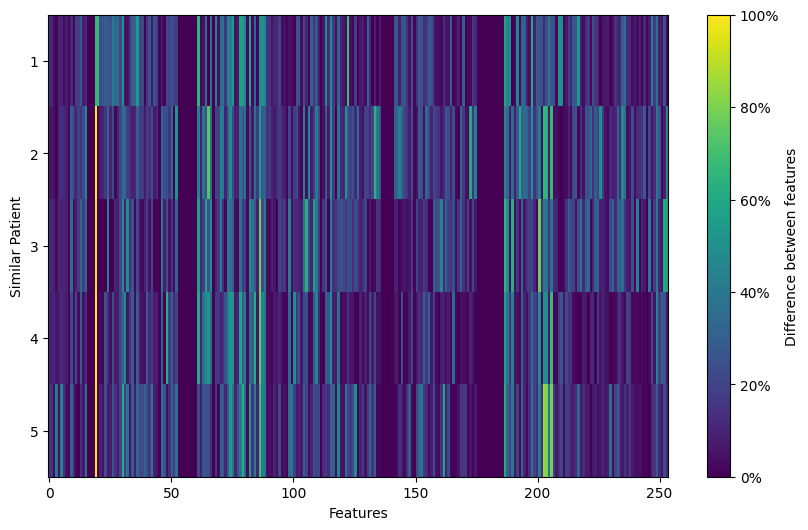

In [29]:
# Difference for similar examples (Day 5) - final
d = 5

subset = model_data.loc[index.loc[d].values.tolist()]
subset = subset.loc[[174, 19649, 11617, 24509, 7930]] # Select only those relevant / unique
subset = subset.iloc[:,2:255]
subset = subset.replace(-1, 0)
difference = subset.sub(final_synthetic_data.iloc[d,2:255].replace(-1, 0)).abs()

# Set the figure size, adjusting the height to make it taller
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the heatmap
bottom = 5.5
top = 0.5
left = -0.5
right = 253.5
extent = [left, right, bottom, top]

im = ax.imshow(difference, cmap='viridis', interpolation='none', aspect='auto', extent=extent)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('Difference between features')
# Change the format of tick labels on the color bar to percentage
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
# Set the range of the color bar to 0 and 1
cbar.mappable.set_clim(vmin=0, vmax=1)

# Set labels and title
#ax.set_title('Similarity Heatmap')
ax.set_xlabel('Features')
ax.set_ylabel('Similar Patient')

plt.show()

In [53]:
### Obtain predictions ###
# Split up dfs
vitals_data = final_synthetic_data.iloc[:,2:255]
demographics_data = final_synthetic_data.iloc[:,255:267]
comorbidity_data = final_synthetic_data.iloc[:, 267:]

# Get labels
labels = final_synthetic_data[['po_flag']]

# Preprocess comorbidity data
print('Working on set_transformer_processing_fun...')
comorbidity_data, comorbidity_mask = set_transformer_processing_fun(comorbidity_data, snomed_embedding)
print('Done!')

#Define batch size
batch_size = len(vitals_data)

# Define dataloaders
train_dataset =  MultiInputDataset([vitals_data, demographics_data], labels, comorbidity_data, comorbidity_mask)
dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

# Define loss
criterion = nn.BCEWithLogitsLoss()

# Evaluate
loss, auroc, predictions, labels_out = evaluate(model, dataloader, criterion)

Working on set_transformer_processing_fun...
Done!


100%|██████████| 1/1 [00:00<00:00, 89.31it/s]


In [54]:
# Apply threshold 
new_predictions = new_threshold_fun(predictions)

In [55]:
predictions
predictions.round()
new_predictions
labels_out

array([0.5       , 0.5       , 0.51413643, 0.62140286, 0.6229846 ,
       0.6671304 ], dtype=float32)

array([0., 0., 1., 1., 1., 1.], dtype=float32)

[0, 0, 0, 0, 0, 0]

array([0., 0., 0., 0., 1., 1.], dtype=float32)